In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from matplotlib import style
import matplotlib.ticker as ticker
from math import sqrt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

# EDA

In [120]:
df= pd.read_csv("CompleteResponses.csv")
df.head()

,salary,age,elevel,car,zipcode,credit,brand
0,119806.54480,45,0,14,4,442037.71130,0
1,106880.47840,63,1,11,6,45007.17883,1
2,78020.75094,23,0,15,2,48795.32279,0
3,63689.93635,51,3,6,5,40888.87736,1
4,50873.61880,20,3,14,4,352951.49770,0


In [7]:
df.isnull().sum()

salary     0
age        0
elevel     0
car        0
zipcode    0
credit     0
brand      0
dtype: int64

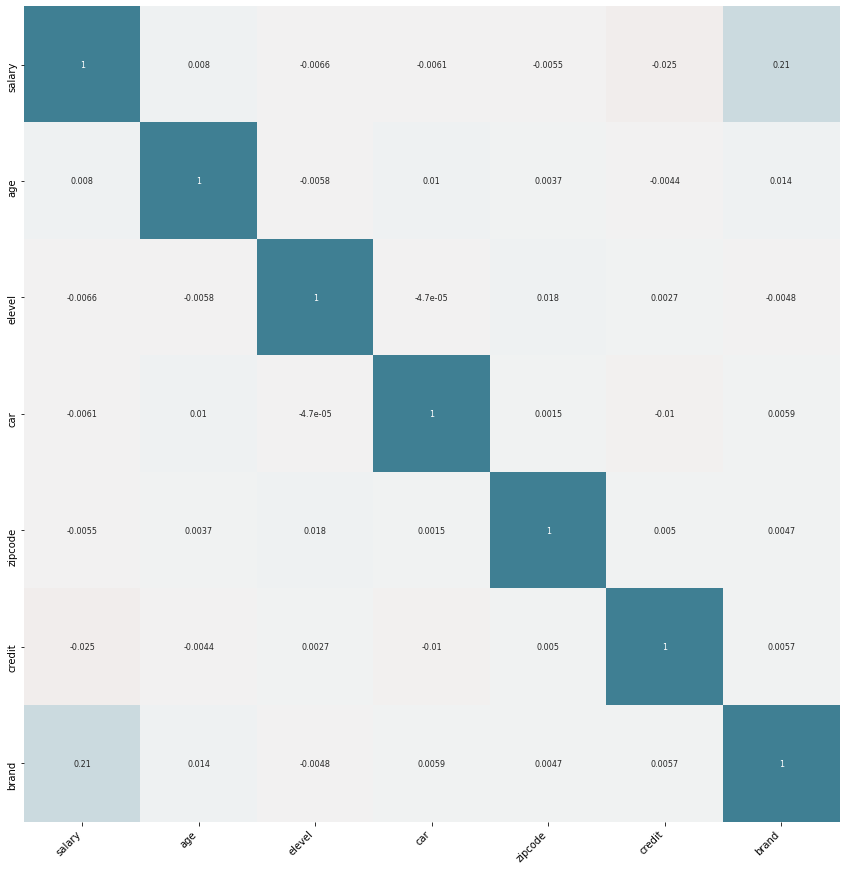

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

sns.heatmap(
    df.corr(),
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [15]:
df.describe()

,salary,age,elevel,car,zipcode,credit,brand
count,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000
mean,84870.862257,49.778642,1.982926,10.521924,4.040816,249175.966620,0.621742
std,37712.340836,17.596685,1.420562,5.771435,2.582058,145211.572531,0.484977
min,20000.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,52082.106040,35.000000,1.000000,6.000000,2.000000,120806.813900,0.000000
50%,84949.735155,50.000000,2.000000,11.000000,4.000000,250607.146100,1.000000
75%,117162.043375,65.000000,3.000000,15.750000,6.000000,374639.701800,1.000000
max,150000.000000,80.000000,4.000000,20.000000,8.000000,500000.000000,1.000000


In [20]:
df.dtypes

salary     float64
age          int64
elevel       int64
car          int64
zipcode      int64
credit     float64
brand        int64
dtype: object

In [22]:
df_new=df.astype({"elevel":"category","car":"category","zipcode":"category","brand":"category"})

# TRAINING Y PREPROCESSING

In [274]:
X=df_new.drop("brand",axis=1)
y=df_new["brand"]
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.75, random_state= 42,stratify=y)

In [275]:
#Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model fitting

In [78]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
modelsC=[]
modelsC.append(("Random Forest Classifier",RandomForestClassifier()))
modelsC.append(("Gradient Boost", GradientBoostingClassifier()))
modelsC.append(("Neural Network",MLPClassifier()))
modelsC.append(("Decision Tree Classifier",DecisionTreeClassifier()))
modelsC.append(("KNN",KNeighborsClassifier()))

In [79]:
from sklearn.model_selection import cross_val_score
results = []
names = []
for name, model in modelsC:
 result = cross_val_score(model, X,y, cv=3, scoring='accuracy')
 names.append(name)
 results.append(result)

In [80]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.9190744057734056
Gradient Boost 0.9091734869152268
Neural Network 0.562448798380899
Decision Tree Classifier 0.8944232565117683
KNN 0.6756912256851632


# Random Forest Clasiffier

In [421]:

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param={"max_depth":np.arange(0,50),"max_features":np.arange(0,50),"min_samples_leaf":np.arange(0,50)}
gbc=RandomForestClassifier()
rcv=RandomizedSearchCV(gbc,param,cv=5)
rcv.fit(X_train,y_train)
display("tuned rfc: {}".format(rcv.best_params_))
display("tuned rfc: {}".format(rcv.best_score_))

"tuned rfc: {'min_samples_leaf': 33, 'max_features': 1, 'max_depth': 48}"

'tuned rfc: 0.7138134380239645'

In [276]:
rfc= RandomForestClassifier(min_samples_leaf= 1, max_features= 5, max_depth=8)
rfc.fit(X_train,y_train)
pred_rfc=rfc.predict(X_test)

In [416]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test, pred_rfc))
print(accuracy_score(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2808
           1       0.94      0.94      0.94      4616

    accuracy                           0.92      7424
   macro avg       0.92      0.92      0.92      7424
weighted avg       0.92      0.92      0.92      7424

[[2534  274]
 [ 287 4329]]
0.9244342672413793


<AxesSubplot:>

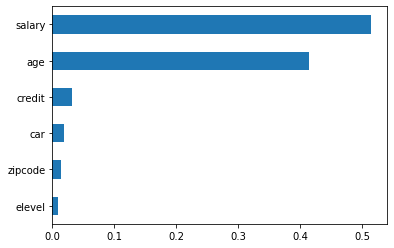

In [283]:

rf_important=pd.Series(rfc.feature_importances_,index=df.drop("brand",axis=1).columns)

sort_important=rf_important.sort_values()

sort_important.plot(kind="barh")

# Gradient Boost

In [419]:

warnings.filterwarnings('ignore')
param={"max_depth":np.arange(0,11),"max_features":np.arange(0,10),"min_samples_leaf":np.arange(0,10)}
gbc=GradientBoostingClassifier()
gcv=RandomizedSearchCV(gbc,param,cv=5)
gcv.fit(X_train,y_train)
display("tuned rfc: {}".format(gcv.best_params_))
display("tuned rfc: {}".format(gcv.best_score_))

"tuned rfc: {'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 8}"

'tuned rfc: 0.9211720443299392'

In [73]:
gfc= GradientBoostingClassifier(min_samples_leaf= 8, max_features= 4, max_depth=4)
gfc.fit(X_train,y_train)
pred_gfc=gfc.predict(X_test)

In [417]:
print(classification_report(y_test,pred_gfc))
print(confusion_matrix(y_test, pred_gfc))
print(accuracy_score(y_test,pred_gfc))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2808
           1       0.94      0.92      0.93      4616

    accuracy                           0.91      7424
   macro avg       0.90      0.91      0.91      7424
weighted avg       0.91      0.91      0.91      7424

[[2543  265]
 [ 390 4226]]
0.9117726293103449


# Preprocessing for logistic regression


In [121]:
dfl=df
dfl.head()

,salary,age,elevel,car,zipcode,credit,brand
0,119806.54480,45,0,14,4,442037.71130,0
1,106880.47840,63,1,11,6,45007.17883,1
2,78020.75094,23,0,15,2,48795.32279,0
3,63689.93635,51,3,6,5,40888.87736,1
4,50873.61880,20,3,14,4,352951.49770,0


In [122]:
dfl=dfl.astype({"car":"str","zipcode":"str","elevel":"str"})
dfl.dtypes

salary     float64
age          int64
elevel      object
car         object
zipcode     object
credit     float64
brand        int64
dtype: object

In [123]:
zipcoden=["New England","Mid-Atlantic","East North Central","West North Central","South Atlantic","East South Central","West South Central","Mountain","Pacific"]
zipcodenu= np.arange(0,9)
zipcode = dict(zip(zipcodenu,zipcoden))

carn=["BMW","Buick","Cadillac","Chevrolet","Chrysler","Dodge","Ford","Honda","Hyunda","Jeep","Kia","Lincoln","Mazda","Mercedes Benz","Mitsubishi","Nissan","Ram","Subaru","Toyota","None of the above"]
carnu=np.arange(1,21)
car=dict(zip(carnu,carn))

eleveln=["no Degree", "High School ", "Some College", "Year College ", "Master Doctoral"]


In [124]:
dfl['zipcode'] = df["zipcode"].map(zipcode)
dfl['car'] = df["car"].map(car)
dfl['elevel'] = df["elevel"].map(elevel)

dfl.head()

,salary,age,elevel,car,zipcode,credit,brand
0,119806.54480,45,no Degree,Mercedes Benz,South Atlantic,442037.71130,0
1,106880.47840,63,High School,Kia,West South Central,45007.17883,1
2,78020.75094,23,no Degree,Mitsubishi,East North Central,48795.32279,0
3,63689.93635,51,Year College,Dodge,East South Central,40888.87736,1
4,50873.61880,20,Year College,Mercedes Benz,South Atlantic,352951.49770,0


In [134]:
dfl1=pd.get_dummies(dfl.elevel)
dfl1=dfl1.drop("no Degree",axis=1)
dfl2=pd.get_dummies(dfl.car)
dfl2=dfl2.drop("Nissan",axis=1)
dfl3=pd.get_dummies(dfl.zipcode)
dfl3=dfl3.drop("South Atlantic",axis=1)

In [135]:
dfl=dfl.drop(["elevel","zipcode","car"],axis=1)

In [139]:
dfl=pd.concat([dfl,dfl1,dfl2,dfl3],axis=1)
dfl.head()

,salary,age,credit,brand,High School,Master Doctoral,Some College,Year College,BMW,Buick,...,Subaru,Toyota,East North Central,East South Central,Mid-Atlantic,Mountain,New England,Pacific,West North Central,West South Central
0,119806.54480,45,442037.71130,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,106880.47840,63,45007.17883,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,78020.75094,23,48795.32279,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,63689.93635,51,40888.87736,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,50873.61880,20,352951.49770,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
X=dfl.drop("brand",axis=1)
y=dfl["brand"]
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.75, random_state= 42,stratify=y)

In [224]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [237]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
result = cross_val_score(model, X,y, cv=3, scoring='roc_auc')
result

array([0.62590867, 0.61723174, 0.61670589])

In [211]:
lr= LogisticRegression()
lr.fit(X_train,y_train)
pred_lr=lr.predict(X_test)

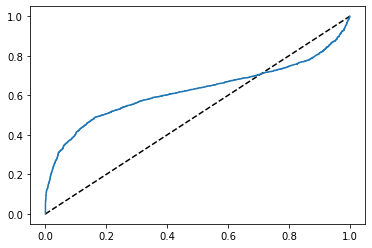

In [212]:
from sklearn.metrics import roc_curve
y_pred_prob=lr.predict_proba(X_test)[:,1]

fpr, tpr, thresholds= roc_curve(y_test,y_pred_prob)
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr, label="Logistic Regression")

# Clustering

In [170]:
dfl.head()

,salary,age,credit,brand,High School,Master Doctoral,Some College,Year College,BMW,Buick,...,Subaru,Toyota,East North Central,East South Central,Mid-Atlantic,Mountain,New England,Pacific,West North Central,West South Central
0,119806.54480,45,442037.71130,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,106880.47840,63,45007.17883,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,78020.75094,23,48795.32279,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,63689.93635,51,40888.87736,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,50873.61880,20,352951.49770,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
scaler = MinMaxScaler()
dfl[["salary","age","credit"]] = scaler.fit_transform(dfl[["salary","age","credit"]])
dfl

,salary,age,credit,brand,High School,Master Doctoral,Some College,Year College,BMW,Buick,...,Subaru,Toyota,East North Central,East South Central,Mid-Atlantic,Mountain,New England,Pacific,West North Central,West South Central
0,0.767743,0.416667,0.884075,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.668311,0.716667,0.090014,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.446313,0.050000,0.097591,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.336076,0.516667,0.081778,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.237489,0.000000,0.705903,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9893,0.519853,0.916667,0.565024,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
9894,0.839857,0.916667,0.769743,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9895,0.598678,0.766667,0.798893,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9896,0.000000,0.066667,0.446409,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [201]:
from sklearn.cluster import KMeans

model= KMeans(n_clusters=2)
model.fit(dfl.drop("brand",axis=1))

KMeans(n_clusters=2)

In [202]:
labels=model.predict(dfl.drop("brand",axis=1))
labels
brand=dfl.brand.to_numpy()
brand

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [203]:
dfc=pd.DataFrame({"labels":labels,"brand":brand})
dfc.head()

,labels,brand
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [204]:
ct=pd.crosstab(dfc.labels,df.brand)
ct

brand,0,1
labels,,
0,2982,4933
1,762,1221


# PRUEBA DE CLASIFICACION CON DUMMIES

In [222]:
modelsC=[]
modelsC.append(("Random Forest Classifier",RandomForestClassifier()))
modelsC.append(("Gradient Boost", GradientBoostingClassifier()))
modelsC.append(("Neural Network",MLPClassifier()))
modelsC.append(("Decision Tree Classifier",DecisionTreeClassifier()))
modelsC.append(("KNN",KNeighborsClassifier()))

In [422]:

results = []
names = []
for name, model in modelsC:
 result = cross_val_score(model, X,y, cv=3, scoring='accuracy')
 names.append(name)
 results.append(result)

In [226]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.8499689529425813
Gradient Boost 0.9031129727098203
Neural Network 0.7587403590313563
Decision Tree Classifier 0.8983634465295575
KNN 0.5538483960551254


In [250]:
gfc= GradientBoostingClassifier()
gfc.fit(X_train,y_train)
pred_gfc=gfc.predict(X_test)

In [251]:
print(classification_report(y_test,pred_gfc))
print(confusion_matrix(y_test, pred_gfc))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2808
           1       0.94      0.92      0.93      4616

    accuracy                           0.91      7424
   macro avg       0.90      0.91      0.91      7424
weighted avg       0.91      0.91      0.91      7424

[[2543  265]
 [ 390 4226]]


# ENSEMBLE votting


In [238]:
from  sklearn.ensemble import VotingClassifier
X=df_new.drop("brand",axis=1)
y=df_new["brand"]
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.75, random_state= 42,stratify=y)

In [239]:
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [247]:
rf=RandomForestClassifier(min_samples_leaf= 1, max_features= 5, max_depth=8)
gb=GradientBoostingClassifier(min_samples_leaf= 8, max_features= 4, max_depth=4)
models=[("Random Forest",rf),("Gradient Boost",gb)]

In [248]:
vc=VotingClassifier(estimators=models)
vc.fit(X_train,y_train)
pred_vc=vc.predict(X_test)

In [254]:
print(classification_report(y_test,pred_vc))
print(confusion_matrix(y_test, pred_vc))
print(accuracy_score(y_test,pred_vc))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2808
           1       0.95      0.92      0.94      4616

    accuracy                           0.92      7424
   macro avg       0.92      0.92      0.92      7424
weighted avg       0.92      0.92      0.92      7424

[[2584  224]
 [ 348 4268]]
0.9229525862068966


# BAGGING

In [262]:
from sklearn.ensemble import BaggingClassifier
bc= BaggingClassifier(base_estimator=rf,n_estimators=300,n_jobs=1,oob_score=True)
bc.fit(X_train,y_train)
pred_bc=bc.predict(X_test)

In [263]:
print(classification_report(y_test,pred_bc))
print(confusion_matrix(y_test, pred_bc))
print(accuracy_score(y_test,pred_bc))
print(bc.oob_score_)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2808
           1       0.94      0.94      0.94      4616

    accuracy                           0.93      7424
   macro avg       0.92      0.92      0.92      7424
weighted avg       0.93      0.93      0.93      7424

[[2534  274]
 [ 278 4338]]
0.9256465517241379
0.9236054971705739


# ADABOOST

In [286]:
from sklearn.ensemble import AdaBoostClassifier
ada= AdaBoostClassifier(base_estimator=rf, n_estimators=100)
ada.fit(X_train,y_train)
pred_ada=ada.predict(X_test)

0.9781452750744345

[[2520  288]
 [ 291 4325]]


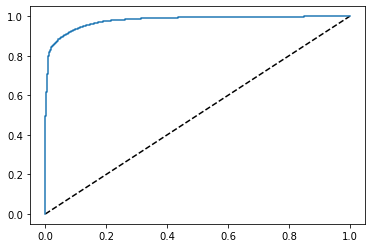

In [291]:
from sklearn.metrics import roc_auc_score
pred_prob_ada=ada.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= roc_curve(y_test,pred_prob_ada)
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr, label="ADA")
display(roc_auc_score(y_test,pred_prob_ada))
print(confusion_matrix(y_test, pred_ada))

# DESPUES DE VERIFICAR LOS MODELOS NOS QUEDAMOS CON BAGGING: CALCULAREMOS MAS VERIFICADORS DE DESEMPEÑO

In [317]:
def compute_log_loss(predicted,actual,eps=1e-14):
    predicted=np.clip(predicted, eps, 1-eps)
    loss= -1 * np.mean(actual*np.log(predicted)+(1-actual)*np.log(1-predicted))
    
    return loss
    

In [318]:
actual=y_test.astype("int")
log_loss=compute_log_loss(pred_prob_bc,actual)
log_loss

0.20294424537280215

In [319]:
pred_prob_bc=bc.predict_proba(X_test)[:,1]
display(roc_auc_score(y_test,pred_prob_bc))

0.9769339396722411

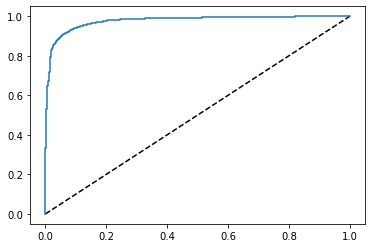

In [418]:
fpr, tpr, thresholds= roc_curve(y_test,pred_prob_bc)
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr, label="BC")



# PREDICCIONES DE MRCA CON DATOS NUEVOS

In [379]:
imcomplete=pd.read_csv("SurveyIncomplete.csv")

In [380]:
incomplete

,salary,age,elevel,car,zipcode,credit,brand
0,150000.00000,76,1,3,3,377980.10160,1
1,82523.83897,51,1,8,3,141657.60660,0
2,115646.63620,34,0,10,2,360980.35850,1
3,141443.39330,22,3,18,2,282736.31910,1
4,149211.27030,56,0,5,3,215667.28960,1
...,...,...,...,...,...,...,...
4995,83891.55966,52,2,14,5,28685.22963,0
4996,125979.28910,71,0,12,7,276614.82930,0
4997,74064.71053,24,2,2,2,202279.57880,0
4998,106485.56710,46,3,16,0,381242.08810,0


In [389]:
to_pred=incomplete.drop("brand",axis=1)

In [390]:
#Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
to_pred = scaler.fit_transform(to_pred)


In [410]:

predictions=bc.predict(to_pred) 
predictions_prob=bc.predict_proba(to_pred)

predictions

TypeError: fit() missing 1 required positional argument: 'y'

In [409]:
pred=pd.DataFrame(columns=["brands"],data=predictions)
proba=pd.DataFrame(columns=["proba_1","proba_0"],data=predictions_prob)
pred

,brands
0,1
1,0
2,1
3,1
4,1
...,...
4995,0
4996,1
4997,0
4998,0


In [413]:
Survey=pd.concat([incomplete.drop("brand",axis=1),pred,proba],axis=1)

In [414]:
Survey

,salary,age,elevel,car,zipcode,credit,brands,proba_1,proba_0
0,150000.00000,76,1,3,3,377980.10160,1,0.000107,0.999893
1,82523.83897,51,1,8,3,141657.60660,0,0.821385,0.178615
2,115646.63620,34,0,10,2,360980.35850,1,0.035645,0.964355
3,141443.39330,22,3,18,2,282736.31910,1,0.000367,0.999633
4,149211.27030,56,0,5,3,215667.28960,1,0.000536,0.999464
...,...,...,...,...,...,...,...,...,...
4995,83891.55966,52,2,14,5,28685.22963,0,0.810730,0.189270
4996,125979.28910,71,0,12,7,276614.82930,1,0.117844,0.882156
4997,74064.71053,24,2,2,2,202279.57880,0,0.980576,0.019424
4998,106485.56710,46,3,16,0,381242.08810,0,0.938850,0.061150


In [415]:
Survey.to_csv("survey.csv")